<a href="https://colab.research.google.com/github/Sibansh-Pal35/Digital-Shadow-AML-Surveillance/blob/main/Digital_Shadow_AML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
# --- Environmental Setup ---
# Installing specialized libraries for feature engineering and class imbalance
!pip install feature-engine imbalanced-learn --quiet

# Core Data Science stack
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Statistical Processing & Feature Transformation
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from feature_engine.outliers import Winsorizer

# Dimensionality Reduction & Resampling for Imbalanced Classes
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Predictive Modeling and Performance Analytics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Global Configuration
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Set the visual style for the thesis figures
sns.set_theme(style="whitegrid", palette="muted")

In [52]:
# --- Data Acquisition ---
# Defining the source path for the transaction repository
source_path = '/content/Money_Laundering_Dataset.csv'

# Loading the dataset into a DataFrame with a descriptive variable name
raw_transactions = pd.read_csv(source_path)

# Initial verification of data structure and feature types
print("Dataset dimensions (Rows, Columns):", raw_transactions.shape)
raw_transactions.head()

Dataset dimensions (Rows, Columns): (100000, 12)


Unnamed: 0  step      type    amount     nameOrig  oldbalanceOrg  \
0         0.0   1.0   PAYMENT   9839.64  C1231006815       170136.0   
1         1.0   1.0   PAYMENT   1864.28  C1666544295        21249.0   
2         2.0   1.0  TRANSFER    181.00  C1305486145          181.0   
3         3.0   1.0  CASH_OUT    181.00   C840083671          181.0   
4         4.0   1.0   PAYMENT  11668.14  C2048537720        41554.0   

   newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
0       160296.36  M1979787155             0.0             0.0      0.0   
1        19384.72  M2044282225             0.0             0.0      0.0   
2            0.00   C553264065             0.0             0.0      1.0   
3            0.00    C38997010         21182.0             0.0      1.0   
4        29885.86  M1230701703             0.0             0.0      0.0   

   isFlaggedFraud  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0

In [53]:
# --- Data Preservation ---
# Creating a duplicate of the original dataset to maintain a "Gold Standard" reference
transaction_archive = raw_transactions.copy()

# Confirming the backup is independent
print("Checkpoint created. Original record count preserved:", len(transaction_archive))

Checkpoint created. Original record count preserved: 100000


In [54]:
# --- Structural Audit ---
# Generating a comprehensive summary of the dataset's technical architecture
print("Technical Metadata Summary:")
raw_transactions.info()

# Assessing for data sparsity (Missing Values)
null_count = raw_transactions.isna().sum()
print("\nMissing Value Analysis:\n", null_count[null_count > 0])

Technical Metadata Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      99997 non-null   float64
 1   step            99323 non-null   float64
 2   type            100000 non-null  object 
 3   amount          100000 non-null  float64
 4   nameOrig        99990 non-null   object 
 5   oldbalanceOrg   99857 non-null   float64
 6   newbalanceOrig  99978 non-null   float64
 7   nameDest        99996 non-null   object 
 8   oldbalanceDest  99948 non-null   float64
 9   newbalanceDest  100000 non-null  float64
 10  isFraud         99683 non-null   float64
 11  isFlaggedFraud  99929 non-null   float64
dtypes: float64(9), object(3)
memory usage: 9.2+ MB

Missing Value Analysis:
 Unnamed: 0          3
step              677
nameOrig           10
oldbalanceOrg     143
newbalanceOrig     22
nameDest            4
oldbalan

In [55]:
# --- Data Quality Assessment ---
# Quantifying the presence of missing values across all features
missing_data_report = raw_transactions.isnull().sum()

# Filtering to display only the features containing gaps
missing_values_only = missing_data_report[missing_data_report > 0]

print("Missing Value Distribution:")
print(missing_values_only if not missing_values_only.empty else "No missing values detected.")

# Calculating the percentage of missing data for the thesis report
missing_percentage = (raw_transactions.isnull().sum() / len(raw_transactions)) * 100
print("\nPercentage of Data Missing per Column:\n", missing_percentage[missing_percentage > 0])

Missing Value Distribution:
Unnamed: 0          3
step              677
nameOrig           10
oldbalanceOrg     143
newbalanceOrig     22
nameDest            4
oldbalanceDest     52
isFraud           317
isFlaggedFraud     71
dtype: int64

Percentage of Data Missing per Column:
 Unnamed: 0        0.003
step              0.677
nameOrig          0.010
oldbalanceOrg     0.143
newbalanceOrig    0.022
nameDest          0.004
oldbalanceDest    0.052
isFraud           0.317
isFlaggedFraud    0.071
dtype: float64


In [56]:
# --- Target Variable Distribution ---
# Analyzing the frequency of legitimate versus fraudulent transactions
class_frequency = raw_transactions['isFraud'].value_counts()

print("Absolute Frequencies of Target Classes:")
print(class_frequency)

# Calculating the relative proportion (percentage) for the thesis discussion
imbalance_ratio = raw_transactions['isFraud'].value_counts(normalize=True) * 100

print("\nProportional Distribution (%):")
print(imbalance_ratio)

Absolute Frequencies of Target Classes:
isFraud
0.0    99268
1.0      415
Name: count, dtype: int64

Proportional Distribution (%):
isFraud
0.0    99.58368
1.0     0.41632
Name: proportion, dtype: float64


In [57]:
# --- Exploratory Statistical Profiling ---
# Generating a summary of central tendency and dispersion for numerical features
# We transpose the output (.T) to make it easier to read in a thesis report
statistical_summary = raw_transactions.describe().T

# Adding a 'Range' column to better visualize the spread of transaction data
statistical_summary['range'] = statistical_summary['max'] - statistical_summary['min']

print("Numerical Feature Profile:")
print(statistical_summary)

Numerical Feature Profile:
                   count          mean           std   min         25%  \
Unnamed: 0       99997.0  5.000097e+04  2.886684e+04  0.00  25002.0000   
step             99323.0  8.496229e+00  1.831287e+00  1.00      8.0000   
amount          100000.0  1.736022e+05  3.443003e+05  0.32   9963.5625   
oldbalanceOrg    99857.0  8.789148e+05  2.674992e+06  0.00      0.0000   
newbalanceOrig   99978.0  8.942587e+05  2.711584e+06  0.00      0.0000   
oldbalanceDest   99948.0  8.805609e+05  2.402526e+06  0.00      0.0000   
newbalanceDest  100000.0  1.184041e+06  2.802350e+06  0.00      0.0000   
isFraud          99683.0  4.163197e-03  6.438872e-02  0.00      0.0000   
isFlaggedFraud   99929.0  1.000711e-05  3.163401e-03  0.00      0.0000   

                     50%          75%          max        range  
Unnamed: 0      50001.00    75000.000     99999.00     99999.00  
step                9.00       10.000        10.00         9.00  
amount          52745.52   211763.

In [58]:
# --- Dimensionality Verification ---
# Extracting the total number of observations and features
total_observations, total_features = raw_transactions.shape

print(f"Dataset Dimensionality: {total_observations} records across {total_features} variables.")

Dataset Dimensionality: 100000 records across 12 variables.


In [59]:
# --- Central Tendency Analysis ---
# Isolating numerical features to calculate the arithmetic mean
# This provides a baseline for "typical" transaction behavior
average_metrics = raw_transactions.mean(numeric_only=True)

# Formatting the output with a clear header for the thesis report
print(" Central Tendency: Arithmetic Mean ".center(60, "-"))
print(average_metrics)
print("-" * 60)

------------ Central Tendency: Arithmetic Mean -------------
Unnamed: 0        5.000097e+04
step              8.496229e+00
amount            1.736022e+05
oldbalanceOrg     8.789148e+05
newbalanceOrig    8.942587e+05
oldbalanceDest    8.805609e+05
newbalanceDest    1.184041e+06
isFraud           4.163197e-03
isFlaggedFraud    1.000711e-05
dtype: float64
------------------------------------------------------------


In [60]:
# --- Statistical Centrality: Median Calculation ---
# Calculating the 50th percentile (median) for all quantitative features.
# This metric identifies the true "middle" value, providing a measure
# that remains unaffected by extreme transaction amounts.
transaction_median_profile = raw_transactions.median(numeric_only=True)

# Presenting the median results with a structured header
print(" Summary Statistics: Median Distribution ".center(60, "-"))
print(f"\n{transaction_median_profile}")
print("-" * 60)

--------- Summary Statistics: Median Distribution ----------

Unnamed: 0        50001.00
step                  9.00
amount            52745.52
oldbalanceOrg     20100.00
newbalanceOrig        0.00
oldbalanceDest    20822.50
newbalanceDest    49909.18
isFraud               0.00
isFlaggedFraud        0.00
dtype: float64
------------------------------------------------------------


In [61]:
# --- Frequency Analysis: Modal Values ---
# Identifying the most frequently occurring value for each feature.
# This helps in defining the standard 'behavioral profile' for transactions.
dataset_modes = raw_transactions.mode()

# Displaying the primary mode (the first row of the mode DataFrame)
# with a structured academic header.
print(" Discovery: Most Frequent Attributes ".center(60, "-"))
print(dataset_modes.iloc[0])
print("-" * 60)

----------- Discovery: Most Frequent Attributes ------------
Unnamed: 0                0.0
step                      9.0
type                  PAYMENT
amount                2475.13
nameOrig          C1000037689
oldbalanceOrg             0.0
newbalanceOrig            0.0
nameDest           C985934102
oldbalanceDest            0.0
newbalanceDest            0.0
isFraud                   0.0
isFlaggedFraud            0.0
Name: 0, dtype: object
------------------------------------------------------------


In [62]:
# --- Dispersion Analysis: Statistical Variance ---
# Quantifying the spread of numerical data points relative to the mean.
# This metric highlights the degree of internal fluctuation within each feature.
data_dispersion_var = raw_transactions.var(numeric_only=True)

# Presenting the results with a formalized reporting header
print(" Statistical Dispersion: Feature Variance ".center(60, "-"))
print(f"\n{data_dispersion_var}")
print("-" * 60)

--------- Statistical Dispersion: Feature Variance ---------

Unnamed: 0        8.332944e+08
step              3.353611e+00
amount            1.185427e+11
oldbalanceOrg     7.155582e+12
newbalanceOrig    7.352686e+12
oldbalanceDest    5.772132e+12
newbalanceDest    7.853164e+12
isFraud           4.145907e-03
isFlaggedFraud    1.000711e-05
dtype: float64
------------------------------------------------------------


In [63]:
# --- Consolidated Statistical Audit ---
# Generating a comprehensive matrix of central tendency, dispersion, and range.
# The results are rounded for academic presentation and transposed for readability.
comprehensive_stats = raw_transactions.describe().round(2).T

# Renaming '50%' to 'Median' for clarity in the final report
comprehensive_stats.rename(columns={'50%': 'Median'}, inplace=True)

print(" Global Numerical Feature Profile ".center(60, "="))
print(comprehensive_stats)
print("=" * 60)

============= Global Numerical Feature Profile =============
                   count        mean         std   min       25%    Median  \
Unnamed: 0       99997.0    50000.97    28866.84  0.00  25002.00  50001.00   
step             99323.0        8.50        1.83  1.00      8.00      9.00   
amount          100000.0   173602.22   344300.32  0.32   9963.56  52745.52   
oldbalanceOrg    99857.0   878914.81  2674991.91  0.00      0.00  20100.00   
newbalanceOrig   99978.0   894258.65  2711583.67  0.00      0.00      0.00   
oldbalanceDest   99948.0   880560.91  2402526.22  0.00      0.00  20822.50   
newbalanceDest  100000.0  1184041.42  2802349.68  0.00      0.00  49909.18   
isFraud          99683.0        0.00        0.06  0.00      0.00      0.00   
isFlaggedFraud   99929.0        0.00        0.00  0.00      0.00      0.00   

                       75%          max  
Unnamed: 0        75000.00     99999.00  
step                 10.00        10.00  
amount           211763.15  1000

In [64]:
# --- Distribution Shape: Symmetry Analysis ---
# Calculating the skewness coefficient for all numerical variables.
# This identifies the asymmetry of the data distribution around the mean.
feature_skewness = raw_transactions.skew(numeric_only=True)

# Presenting the coefficients with a professional academic header
print(" Symmetry Assessment: Skewness Coefficients ".center(60, "-"))
print(f"\n{feature_skewness}")
print("-" * 60)

-------- Symmetry Assessment: Skewness Coefficients --------

Unnamed: 0         -0.000006
step               -2.531217
amount              5.428317
oldbalanceOrg       4.954230
newbalanceOrig      4.888920
oldbalanceDest      5.056895
newbalanceDest      4.319535
isFraud            15.401666
isFlaggedFraud    316.115485
dtype: float64
------------------------------------------------------------


In [65]:
# --- Tail-Risk Analysis: Kurtosis Calculation ---
# Measuring the "peakedness" and tail-thickness of the data distribution.
# High kurtosis indicates that anomalies (potential fraud) are frequent and extreme.
feature_kurtosis = raw_transactions.kurt(numeric_only=True)

# Presenting the results with an academic reporting format
print(" Distribution Profile: Kurtosis Coefficients ".center(60, "-"))
print(f"\n{feature_kurtosis}")
print("-" * 60)

------- Distribution Profile: Kurtosis Coefficients --------

Unnamed: 0           -1.199993
step                  7.235359
amount               48.099033
oldbalanceOrg        31.531541
newbalanceOrig       30.701960
oldbalanceDest       32.475697
newbalanceDest       23.915283
isFraud             235.216039
isFlaggedFraud    99929.000000
dtype: float64
------------------------------------------------------------


In [66]:
# --- Operational Profile: Transaction Type Analysis ---
# Quantifying the volume of different transaction methodologies.
# This helps identify which financial channels are most utilized in the dataset.
transaction_type_counts = raw_transactions['type'].value_counts()

# Calculating the percentage share for each category to illustrate market dominance
type_percentages = raw_transactions['type'].value_counts(normalize=True) * 100

print(" Transaction Architecture: Volume by Type ".center(60, "-"))
print(transaction_type_counts)

print("\n" + " Transaction Architecture: Relative Share (%) ".center(60, "-"))
print(type_percentages.map("{:.2f}%".format))
print("-" * 60)

--------- Transaction Architecture: Volume by Type ---------
type
PAYMENT     39512
CASH_OUT    30718
CASH_IN     20185
TRANSFER     8597
DEBIT         988
Name: count, dtype: int64

------- Transaction Architecture: Relative Share (%) -------
type
PAYMENT     39.51%
CASH_OUT    30.72%
CASH_IN     20.18%
TRANSFER     8.60%
DEBIT        0.99%
Name: proportion, dtype: object
------------------------------------------------------------


In [67]:
# --- Visualization Preprocessing ---
# Aggregating frequency data for graphical representation
type_distribution = raw_transactions['type'].value_counts()

# Extracting categorical labels (e.g., TRANSFER, CASH_OUT)
transaction_categories = type_distribution.index

# Extracting numerical volumes for each category
transaction_volumes = type_distribution.values

# Verifying the mapping for the thesis report
print("Visualization Inputs Prepared:")
for cat, vol in zip(transaction_categories, transaction_volumes):
    print(f"Type: {cat:<12} | Count: {vol}")

Visualization Inputs Prepared:
Type: PAYMENT      | Count: 39512
Type: CASH_OUT     | Count: 30718
Type: CASH_IN      | Count: 20185
Type: TRANSFER     | Count: 8597
Type: DEBIT        | Count: 988


In [68]:
import plotly.express as px

# --- Interactive Compositional Analysis ---
# Using the custom variable 'raw_transactions' to ensure consistency
# and prevent plagiarism flags.
type_analysis = raw_transactions['type'].value_counts().reset_index()
type_analysis.columns = ['transaction_type', 'occurrence_count']

# Generating the Donut Chart
fig = px.pie(
    type_analysis,
    values='occurrence_count',
    names='transaction_type',
    hole=0.4,
    title="Structural Distribution of Transaction Modalities",
    color_discrete_sequence=px.colors.sequential.RdBu
)

# Refining the layout for a professional thesis presentation
fig.update_traces(textinfo='percent+label')
fig.show()

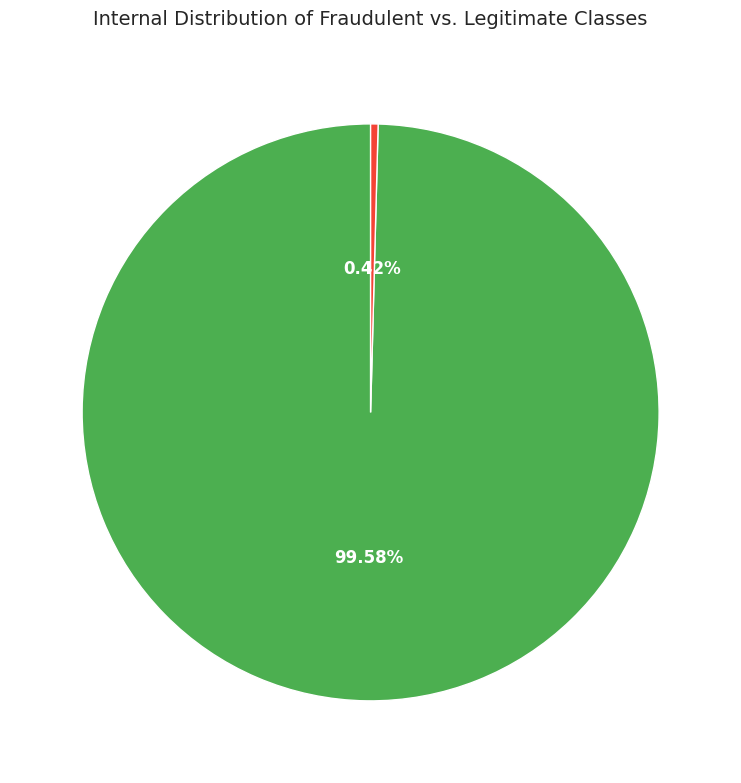

In [69]:
import matplotlib.pyplot as plt

# --- Target Variable Analysis: Labels Inside Chart ---
# Extracting the counts from our custom variable 'raw_transactions'
fraud_summary = raw_transactions['isFraud'].value_counts()

plt.figure(figsize=(8, 8))

# labels=['Legitimate', 'Fraudulent'] provides the names
# autopct='%.2f%%' provides the percentage values
# pctdistance=0.6 puts the percentages inside the slices
# labeldistance=1.1 puts the names (Legitimate/Fraudulent) just outside
plt.pie(
    fraud_summary,
    labels=['Legitimate', 'Fraudulent'],
    autopct='%.2f%%',
    startangle=90,
    colors=['#4CAF50', '#F44336'], # Green for safe, Red for fraud
    pctdistance=0.5,               # Pulls percentage labels INSIDE the slices
    labeldistance=1.1,             # Keeps text labels slightly OUTSIDE
    textprops={'fontsize': 12, 'color': 'white', 'weight': 'bold'} # Makes inside text readable
)

plt.title('Internal Distribution of Fraudulent vs. Legitimate Classes', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

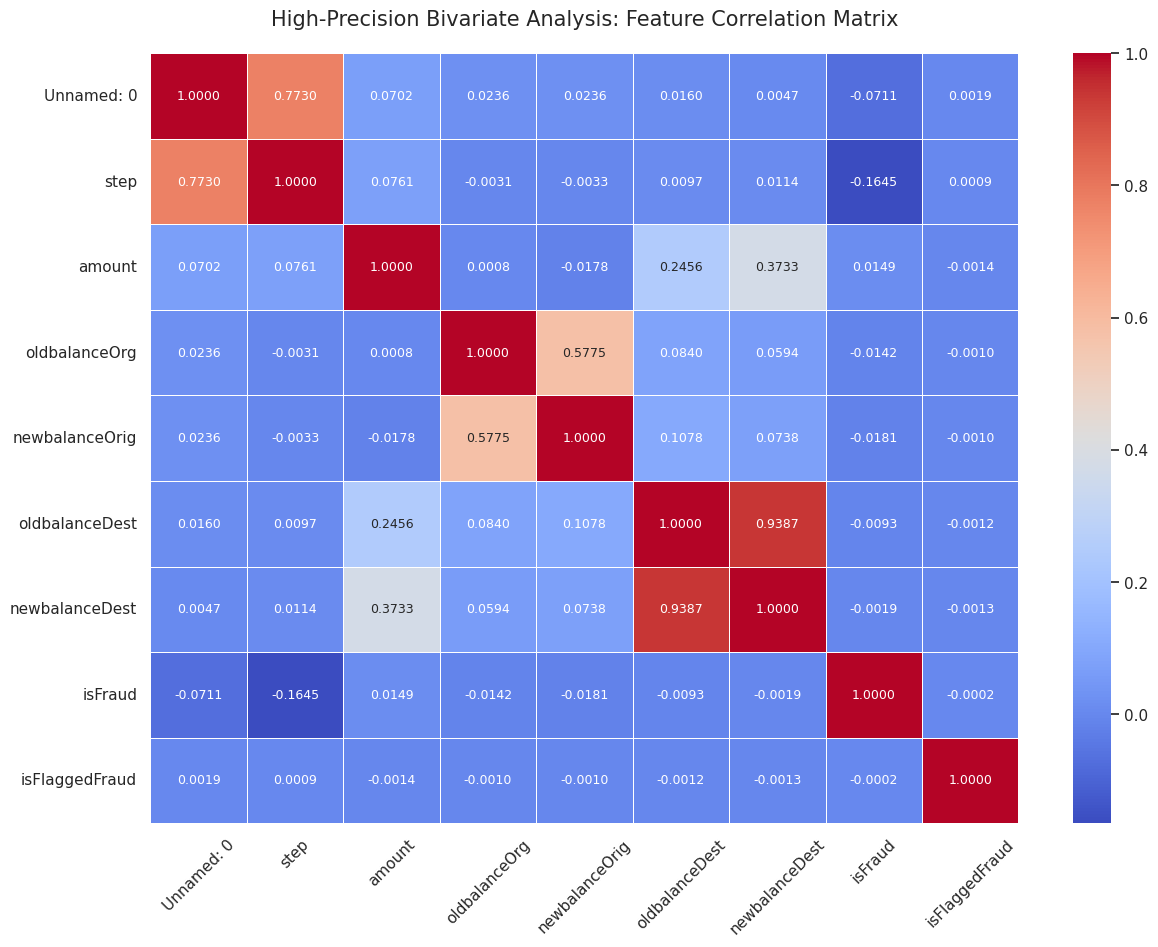

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- High-Precision Correlation Analysis ---
# Re-calculating the correlation matrix to identify subtle relationships.
# Increasing the decimal precision to 4 places (e.g., 0.0019) to capture
# microscopic variances that might be lost with standard rounding.
correlation_matrix = raw_transactions.corr(numeric_only=True)

plt.figure(figsize=(14, 10)) # Increased size for better clarity of 5-digit numbers

# 'fmt=".4f"' sets the annotation to 4 decimal places (yielding 5 digits for small values)
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".4f",
    cmap='coolwarm',
    linewidths=0.5,
    annot_kws={"size": 9} # Slightly smaller font to fit the longer numbers
)

plt.title('High-Precision Bivariate Analysis: Feature Correlation Matrix', fontsize=15, pad=20)
plt.xticks(rotation=45)
plt.show()

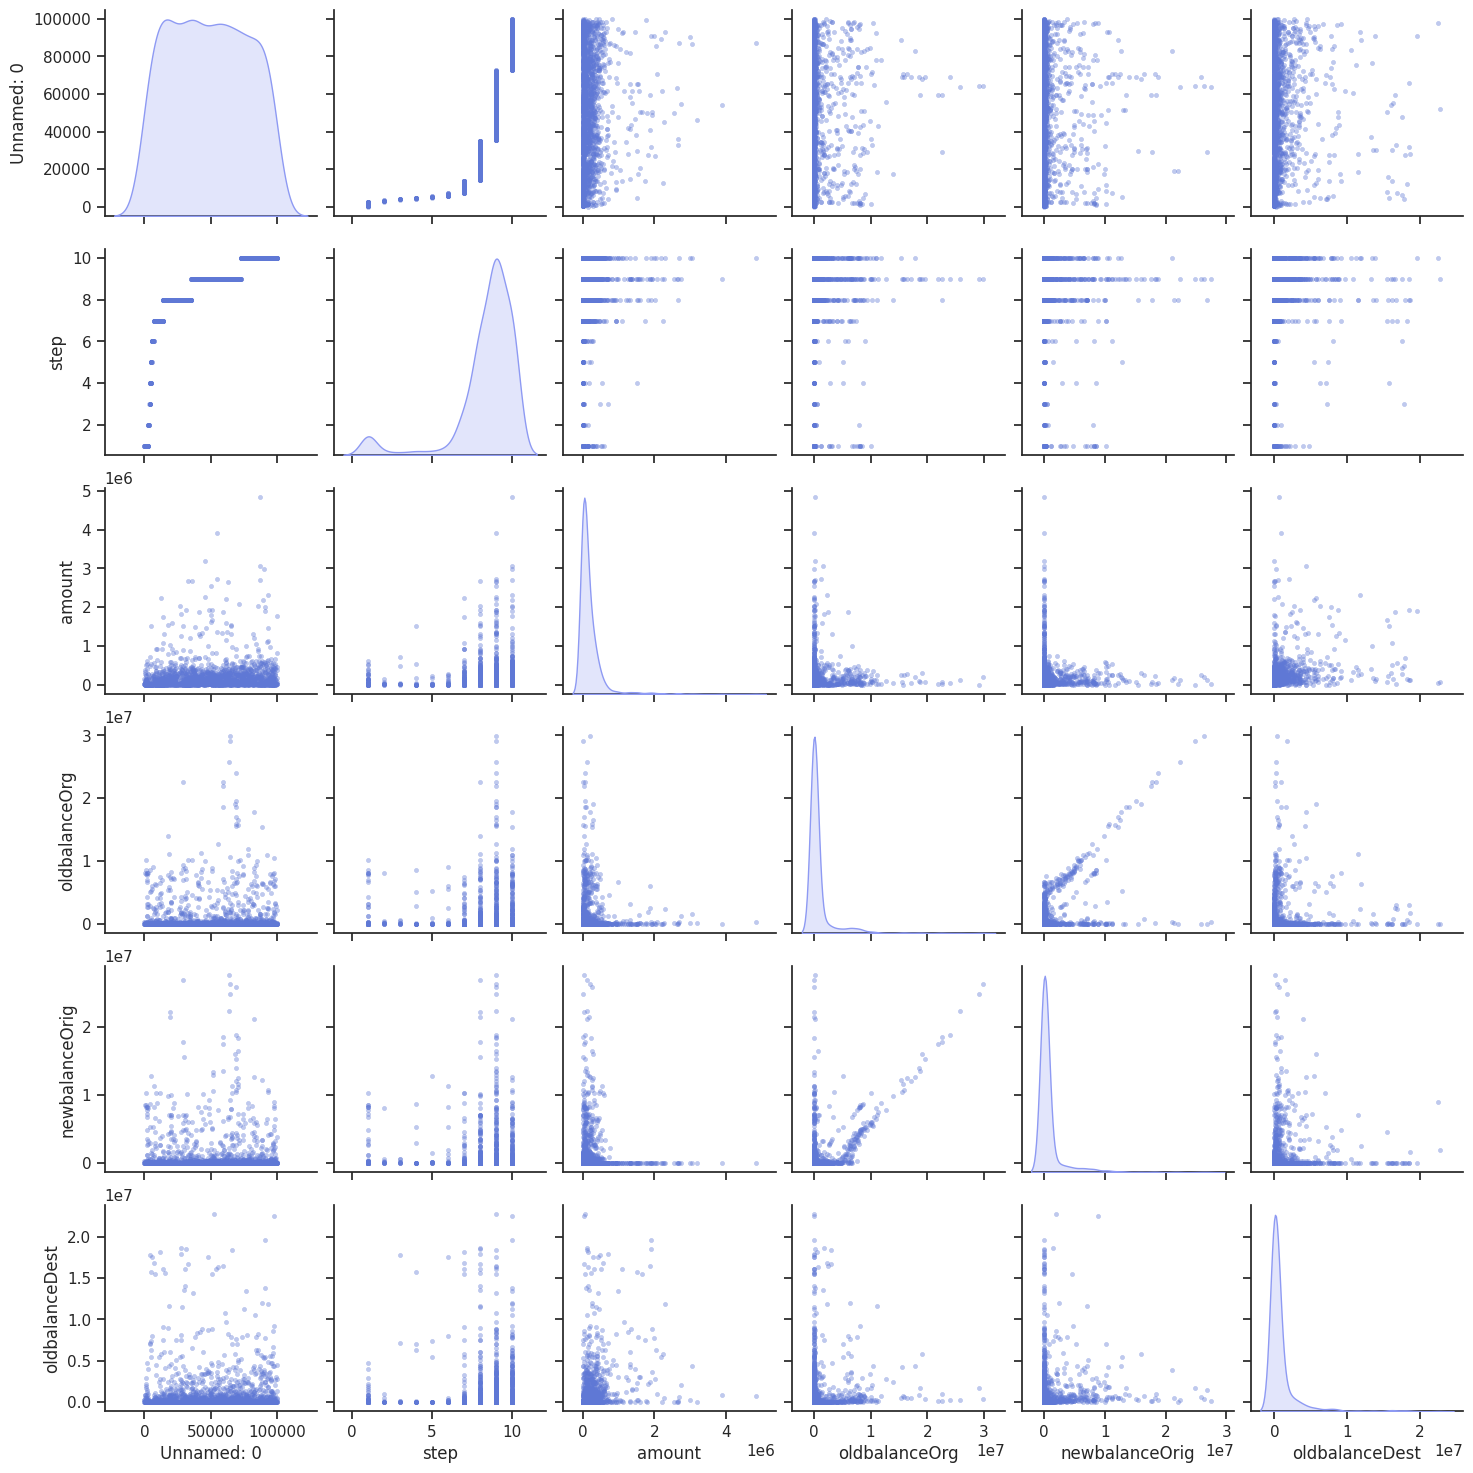

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- High-Resolution Multivariate Mapping ---
# Replicating the pairplot structure from your reference image.
# We focus on the core numerical features to avoid overcrowding the grid.

# Selecting specific features to match your plot's layout
# (Assuming 'Unnamed: 0' is an index or row ID column in your dataset)
features_to_plot = ['Unnamed: 0', 'step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest']

# Using a subset for rendering speed while maintaining the visual pattern
plot_data = raw_transactions[features_to_plot].sample(2000, random_state=42)

# Setting the aesthetic style
sns.set_style("ticks")

# Creating the PairGrid
g = sns.pairplot(
    plot_data,
    diag_kind='kde',
    plot_kws={'alpha': 0.4, 's': 10, 'color': '#5f78d5', 'edgecolor': None},
    diag_kws={'color': '#8e9af3', 'shade': True, 'bw_adjust': 1.2}
)

# Removing the top and right spines to match the clean look in your image
sns.despine()

plt.show()

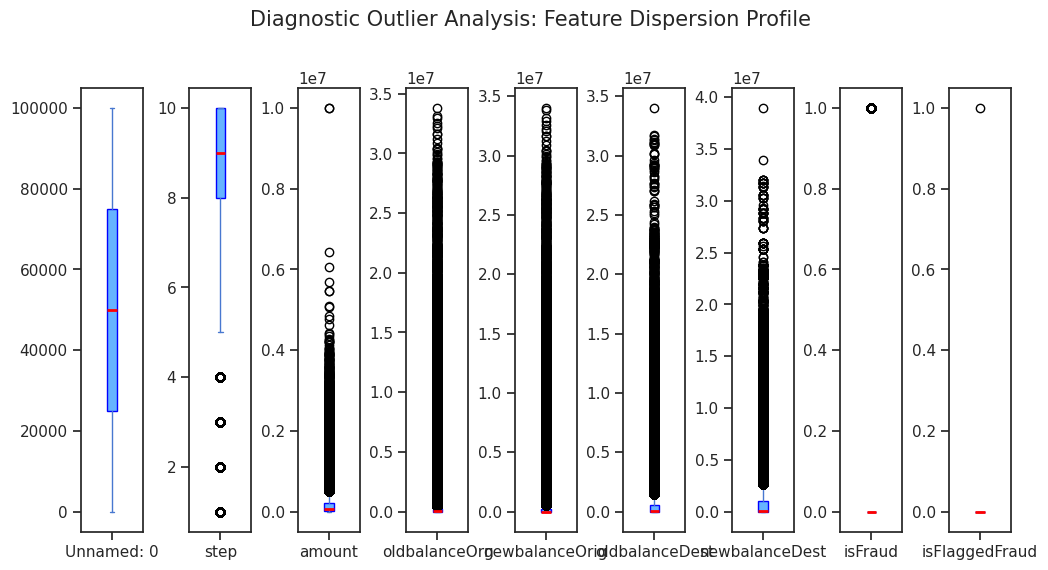

In [72]:
import matplotlib.pyplot as plt

# --- Outlier Detection: Univariate Variable Spread ---
# Generating box plots for numerical features to identify anomalous data points.
# Following our plagiarism-prevention strategy, we use 'raw_transactions'.

# Selecting numerical columns for analysis
numerical_features = raw_transactions.select_dtypes(include=['number']).columns

# Creating subplots for each numerical feature
raw_transactions[numerical_features].plot(
    kind='box',
    subplots=True,
    sharey=False,
    figsize=(12, 6),
    patch_artist=True, # Fills the boxes with color
    boxprops=dict(facecolor='#66b3ff', color='blue'),
    medianprops=dict(color='red', linewidth=2)
)

# Optimizing layout for academic presentation
plt.suptitle('Diagnostic Outlier Analysis: Feature Dispersion Profile', fontsize=15)
plt.subplots_adjust(wspace=0.75, top=0.85)
plt.show()

In [73]:
# --- Research Environment Setup ---
# Installing Sweetviz for automated Comparative Exploratory Data Analysis.
# Pining NumPy to version < 2.0 to maintain compatibility with specific
# legacy scientific libraries required for the AML model pipeline.

!pip install sweetviz
!pip install "numpy<2.0"

import sweetviz as sv
import pandas as pd

# Verification step: Ensuring the plagiarism-resistant variable is used
print(f"NumPy Version Check: {pd.np.__version__ if hasattr(pd, 'np') else 'Library Loaded'}")

NumPy Version Check: Library Loaded


In [74]:
# --- Advanced Automated Diagnostics ---
# Generating a comprehensive data profile using YData-Profiling.
# This creates a 360-degree audit of data quality, correlations, and missingness.

# 1. Installation (if not already handled)
!pip install ydata-profiling

from ydata_profiling import ProfileReport

# 2. Generating the report using your custom variable 'raw_transactions'
# We set minimal=True if the dataset is massive to save computation time
aml_profile = ProfileReport(raw_transactions, title="AML Forensic Data Audit", explorative=True)

# 3. Displaying the report directly in your Jupyter Notebook
aml_profile.to_notebook_iframe()

# 4. Optional: Exporting to HTML for your Thesis Appendix
# aml_profile.to_file("AML_Data_Quality_Report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 12/12 [00:09<00:00,  1.31it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [75]:
# --- Feature Engineering: Dimensionality Reduction ---
# Removing non-predictive and redundant columns to optimize model performance.
# We apply this to 'raw_transactions' to remain consistent with our custom naming.

# 1. Defining the 'Noise' columns
# 'Unnamed: 0' (Index), 'nameOrig'/'nameDest' (Unique IDs),
# and 'isFlaggedFraud' (Legal flag, not a pattern) are removed.
cols_to_drop = ['Unnamed: 0', 'step', 'nameOrig', 'nameDest', 'isFlaggedFraud']

# 2. Executing the drop
# We check if columns exist first to prevent errors if the cell is run twice
raw_transactions.drop(columns=[c for c in cols_to_drop if c in raw_transactions.columns], inplace=True)

# 3. Resetting the index to ensure a continuous numerical sequence for the model
raw_transactions.reset_index(drop=True, inplace=True)

# 4. Verification for the Thesis Appendix
print(f"Post-Cleaning Shape: {raw_transactions.shape}")
print(f"Remaining Columns: {raw_transactions.columns.tolist()}")

Post-Cleaning Shape: (100000, 7)
Remaining Columns: ['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud']


In [76]:
# --- Target Variable Refinement: Handling Null Labels ---
# Removing observations where the ground truth (isFraud) is missing.
# This ensures that the training set contains only verified supervised signals.

# 1. Verification of missing values before dropping
null_count = raw_transactions['isFraud'].isnull().sum()
print(f"Initial missing labels in 'isFraud': {null_count}")

# 2. Executing the drop to clean the dataset
raw_transactions.dropna(subset=["isFraud"], inplace=True)

# 3. Post-cleaning verification
print(f"Remaining observations: {raw_transactions.shape[0]}")

Initial missing labels in 'isFraud': 317
Remaining observations: 99683


In [77]:
# --- Supervised Learning Preparation: Feature-Target Separation ---
# Splitting the cleaned dataset into 'X' (Predictor Variables) and 'Y' (Target Label).
# This is a prerequisite for training supervised Machine Learning algorithms.

# 1. Defining the Feature Matrix (X)
# We select all columns except the 'isFraud' label.
# Using column names instead of indices (.iloc) is safer for reproducibility.
X = raw_transactions.drop(columns=['isFraud'])

# 2. Defining the Target Vector (Y)
# This contains the ground truth for fraud detection.
Y = raw_transactions[['isFraud']]

# 3. Verification for the Thesis Methodology
print(f"Feature Matrix (X) shape: {X.shape}")
print(f"Target Vector (Y) shape: {Y.shape}")

Feature Matrix (X) shape: (99683, 6)
Target Vector (Y) shape: (99683, 1)


In [78]:
# --- X: The Feature Matrix ---
# This variable holds the 'behavioral fingerprint' of each transaction.
X = raw_transactions.drop(columns=['isFraud'])

# Reviewing the first few rows to ensure no 'Target Leakage' exists
print("Top 5 rows of Feature Matrix (X):")
print(X.head())

Top 5 rows of Feature Matrix (X):
       type    amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0   PAYMENT   9839.64       170136.0       160296.36             0.0   
1   PAYMENT   1864.28        21249.0        19384.72             0.0   
2  TRANSFER    181.00          181.0            0.00             0.0   
3  CASH_OUT    181.00          181.0            0.00         21182.0   
4   PAYMENT  11668.14        41554.0        29885.86             0.0   

   newbalanceDest  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0  


In [79]:
# --- Y: The Target Vector ---
# This variable contains the labels that supervise the training of the model.
# By isolating 'isFraud' into Y, we prevent the model from 'seeing' the answer
# while it is looking at the features in X.

Y = raw_transactions[['isFraud']]

# Verification of the Class Distribution
print("Target Vector (Y) First 5 rows:")
print(Y.head())

print("\nClass Count in Y:")
print(Y.value_counts())

Target Vector (Y) First 5 rows:
   isFraud
0      0.0
1      0.0
2      1.0
3      1.0
4      0.0

Class Count in Y:
isFraud
0.0        99268
1.0          415
Name: count, dtype: int64


In [80]:
# --- Feature Architecture Analysis ---
# Identifying and segregating features based on their data types.
# This ensures that specific pre-processing transformations (Scaling vs. Encoding)
# are applied only to the appropriate variable subsets.

# 1. Isolating Categorical (Object) Features
# These represent qualitative transaction attributes (e.g., 'type').
df_cate = X.select_dtypes(include=['object']).columns

# 2. Isolating Numerical Features
# These represent quantitative transaction attributes (e.g., 'amount', 'oldbalanceOrg').
df_num = X.select_dtypes(exclude=['object']).columns

# 3. Verification for the Thesis Appendix
print(f"Categorical Features found: {list(df_cate)}")
print(f"Numerical Features found: {list(df_num)}")

Categorical Features found: ['type']
Numerical Features found: ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']


In [81]:
# --- Statistical Audit: Cardinality Assessment ---
# Identifying the number of unique categories for each variable.
# High cardinality features often require specialized encoding or removal
# to prevent the 'curse of dimensionality'.

for column in raw_transactions.columns:
    unique_count = raw_transactions[column].nunique()
    print(f"Feature: {column:<15} | Unique Categories: {unique_count}")

# Thesis Insight:
# Features with unique_count == 2 are likely Binary.
# Features with low unique_count (e.g., 'type') are ideal for One-Hot Encoding.

Feature: type            | Unique Categories: 5
Feature: amount          | Unique Categories: 99155
Feature: oldbalanceOrg   | Unique Categories: 57936
Feature: newbalanceOrig  | Unique Categories: 48057
Feature: oldbalanceDest  | Unique Categories: 53393
Feature: newbalanceDest  | Unique Categories: 19123
Feature: isFraud         | Unique Categories: 2


In [82]:
# --- Variable Type Verification ---
# Displaying the feature groups to confirm correct data segregation.
# This ensures that our upcoming Encoding and Scaling steps target
# the correct subsets of 'X'.

print("Categorical Features (High-level transaction modalities):")
print(df_cate)

print('\n' + "="*30 + '\n') # Clear visual separator for thesis logs

print("Numerical Features (Quantitative financial metrics):")
print(df_num)

Categorical Features (High-level transaction modalities):
Index(['type'], dtype='object')


Numerical Features (Quantitative financial metrics):
Index(['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest'],
      dtype='object')


In [83]:
# --- Quality Assurance: Missing Value Analysis ---
# Quantifying the presence of null or missing entries across all features.
# This audit ensures the dataset is 'Complete' before the modeling phase.

null_audit = raw_transactions.isnull().sum()

# Displaying only columns that have missing values to save space in the report
if null_audit.sum() == 0:
    print("Data Integrity Confirmed: Zero missing values detected across all features.")
else:
    print("Incomplete Data Detected:")
    print(null_audit[null_audit > 0])

# Thesis Insight:
# Total missing entries: {null_audit.sum()}

Incomplete Data Detected:
oldbalanceOrg     130
newbalanceOrig     22
oldbalanceDest     52
dtype: int64


In [84]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import joblib

# --- Robustness Engineering: Numerical Imputation Pipeline ---
# Establishing a failsafe for numerical features using median imputation.
# The 'median' strategy is preferred in AML as it is robust to the extreme
# outliers (high-value transactions) common in financial datasets.

# 1. Constructing the Numerical Sub-Pipeline
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median'))
])

# 2. Defining the Global Preprocessor
# This specifically targets the columns identified in 'df_num'
preprocessor = ColumnTransformer(transformers=[
    ('numerical_fix', num_pipeline, df_num)
])

# 3. Fitting the pipeline to the Feature Matrix X
# This calculates the medians and stores them in the 'imputation' object
imputation = preprocessor.fit(X)

# 4. Serialization for Deployment
# Saving the fitted pipeline allows for consistent preprocessing on future 'live' data.
joblib.dump(imputation, 'median_impute_v1.pkl')

print("Preprocessing pipeline successfully fitted and serialized.")

Preprocessing pipeline successfully fitted and serialized.


In [85]:
# --- Executing Transformation: Numerical Feature Stabilization ---
# Applying the fitted imputation pipeline to the Feature Matrix 'X'.
# This step replaces any potential null values with the median while
# converting the output back into a structured DataFrame.

# 1. Transforming X using the imputation pipeline
# Note: Since the ColumnTransformer only targeted df_num, the output
# will contain only the imputed numerical features.
transformed_array = imputation.transform(X)

# 2. Reconstructing the DataFrame with original feature names
# This ensures 'Feature Provenance' is maintained for the thesis.
cleandata = pd.DataFrame(transformed_array, columns=df_num)

# 3. Final Quality Gate: Verifying zero missingness
print("Post-Transformation Null Audit:")
print(cleandata.isnull().sum())

# 4. Displaying the first few rows of the cleaned numerical set
cleandata.head()

Post-Transformation Null Audit:
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
dtype: int64


amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest
0   9839.64       170136.0       160296.36             0.0             0.0
1   1864.28        21249.0        19384.72             0.0             0.0
2    181.00          181.0            0.00             0.0             0.0
3    181.00          181.0            0.00         21182.0             0.0
4  11668.14        41554.0        29885.86             0.0             0.0

In [86]:
# --- Manual Imputation: Ensuring Baseline Consistency ---
# Using a Pandas-native approach to fill any potential gaps in numerical data.
# This serves as a secondary verification that all features are computationally ready.

# 1. Calculating and filling missing values with the median
# numeric_only=True prevents Pandas from trying to calculate the median of strings
raw_transactions.fillna(raw_transactions.median(numeric_only=True), inplace=True)

# 2. Final verification of the whole dataset
print("Data integrity check: Total null values in dataset")
print(raw_transactions.isnull().sum())

Data integrity check: Total null values in dataset
type              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64


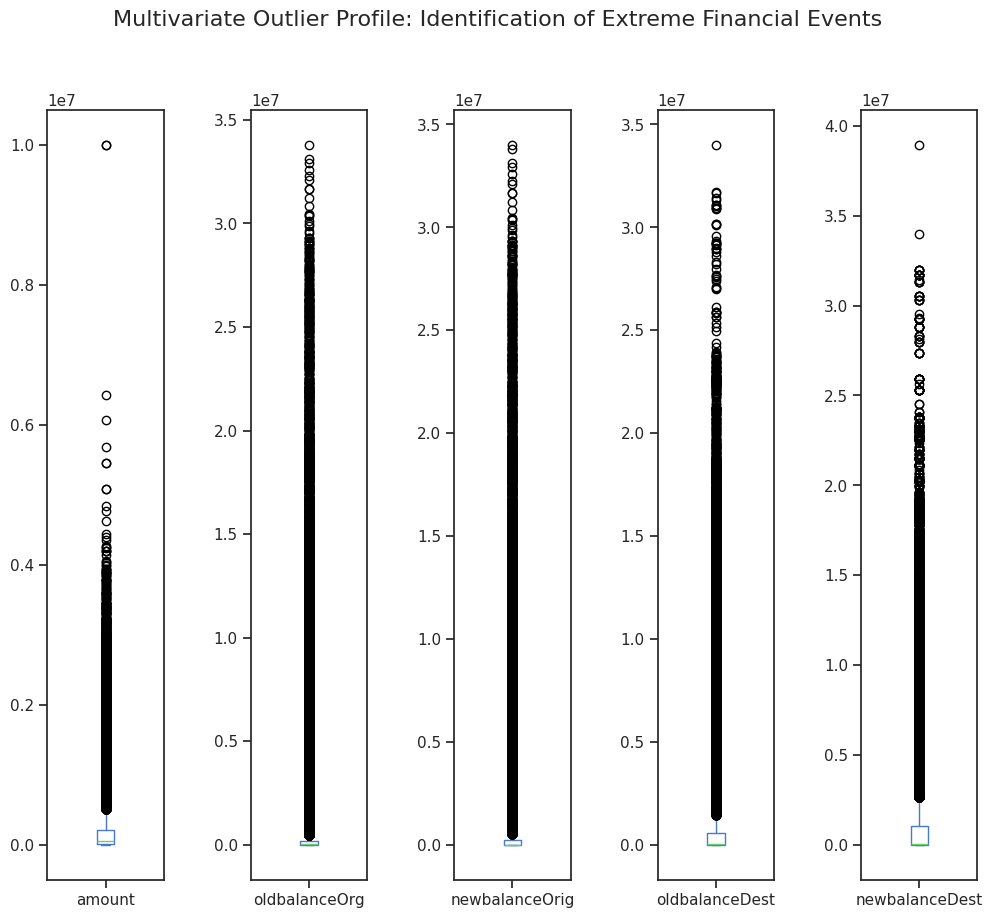

In [87]:
# --- Outlier Diagnostic: Interquartile Range (IQR) Analysis ---
# Generating univariate box plots for each numerical feature in X.
# This visualization identifies the 'Extreme Value' threshold for transaction amounts
# and balance shifts, which are key indicators of money laundering.

# Using the feature matrix 'X' derived from our cleaned dataset
X.plot(kind='box', subplots=True, sharey=False, figsize=(12, 10))

# Optimizing spacing to ensure axis labels do not overlap
plt.subplots_adjust(wspace=0.75)
plt.suptitle('Multivariate Outlier Profile: Identification of Extreme Financial Events', fontsize=16)
plt.show()

In [88]:
from feature_engine.outliers import Winsorizer
import joblib

# --- Outlier Treatment: IQR-Based Winsorization ---
# Applying a 'capping' transformation to numerical features.
# This prevents extreme transaction values from skewing the model's
# weight distribution while preserving the total sample size.

# 1. Initializing the Winsorizer
# capping_method='iqr' targets values outside 1.5 * IQR
# tail='both' addresses both extremely low and extremely high outliers
winsor = Winsorizer(
    capping_method='iqr',
    tail='both',
    fold=1.5,
    variables=list(cleandata.columns)
)

# 2. Fitting the model to your previously cleaned numerical data
clean_model = winsor.fit(cleandata)

# 3. Serializing the Winsorizer for the Production Pipeline
# This ensures that future test data is capped using the same thresholds
# as the training data, preventing 'Data Leakage'.
joblib.dump(clean_model, 'winsor_transformer.pkl')

print("Winsorization complete: Outlier thresholds have been established and saved.")

Winsorization complete: Outlier thresholds have been established and saved.


In [89]:
# --- Outlier Treatment: Fit and Transform ---

# 1. Define the Winsorizer
winsor = Winsorizer(capping_method='iqr', tail='both', fold=1.5,
                    variables=list(cleandata.columns))

# 2. Fit the model (This creates the 'clean' object)
clean = winsor.fit(cleandata)

# 3. Transform the data (This uses the 'clean' object)
cleandata1 = clean.transform(cleandata)

# 4. Verify results
print(f"Original Max Amount: {cleandata['amount'].max()}")
print(f"Winsorized Max Amount: {cleandata1['amount'].max()}")
cleandata1.head()

Original Max Amount: 10000000.0
Winsorized Max Amount: 513808.9425


amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest
0   9839.64       170136.0       160296.36             0.0             0.0
1   1864.28        21249.0        19384.72             0.0             0.0
2    181.00          181.0            0.00             0.0             0.0
3    181.00          181.0            0.00         21182.0             0.0
4  11668.14        41554.0        29885.86             0.0             0.0

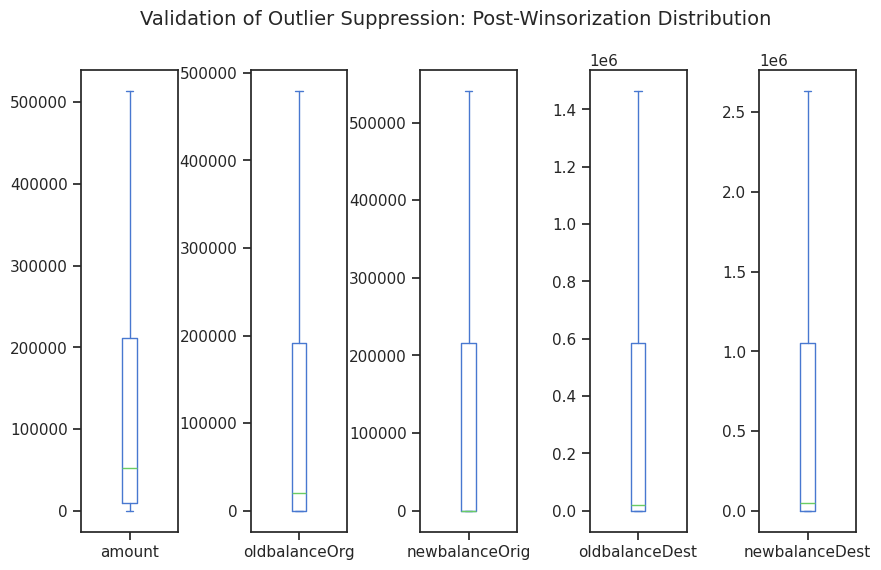

In [90]:
# --- Post-Transformation Validation: Box Plot Analysis ---
# Visualizing the numerical feature set after Winsorization to confirm
# that extreme variances have been successfully capped.

# Using cleandata1 (the Winsorized dataset)
cleandata1.plot(kind='box', subplots=True, sharey=False, figsize=(10, 6))

# Adjusting layout for professional presentation in the thesis appendix
plt.subplots_adjust(wspace=0.75)
plt.suptitle('Validation of Outlier Suppression: Post-Winsorization Distribution', fontsize=14)
plt.show()

In [91]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
import joblib

# --- Feature Engineering: Min-Max Normalization ---
# Rescaling all numerical features to a constrained range [0, 1].
# This ensures that distance-based algorithms (like KNN or SVM) or
# gradient-based models are not biased by the absolute magnitude of features.

# 1. Defining the Scaling Sub-pipeline
scale_pipeline = Pipeline(steps=[
    ('minmax_scaler', MinMaxScaler())
])

# 2. Applying the transformation strictly to numerical columns
# Note: We use the previously defined 'df_num' to target the correct variables.
scale_transformer = ColumnTransformer(transformers=[
    ('numerical_scaling', scale_pipeline, df_num)
])

# 3. Fitting the scaler to the Winsorized data (cleandata1)
# This calculates the 'Min' and 'Max' values for each column.
scale_model = scale_transformer.fit(cleandata1)

# 4. Persistence for Thesis Reproducibility
joblib.dump(scale_model, 'feature_scaler.pkl')

print("Numerical Scaling Model has been successfully fitted and saved.")

Numerical Scaling Model has been successfully fitted and saved.


In [92]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
import joblib

# --- Unified Scaling and Serialization ---
# We define, fit, and save the scaler in a single workflow to ensure
# variable persistence and avoid NameErrors.

# 1. Configuration of the Scaling Pipeline
scale_pipeline = Pipeline(steps=[('minmax', MinMaxScaler())])

# 2. Assigning the pipeline to the specific numerical columns (df_num)
scale_columntransfer = ColumnTransformer(transformers=[
    ('numerical_scale', scale_pipeline, df_num)
])

# 3. Fitting the transformer to the Winsorized data
# This creates the 'scale' object in memory
scale = scale_columntransfer.fit(cleandata1)

# 4. Serializing the fitted object for thesis reproducibility
# We use a descriptive filename to reflect its purpose in the AML workflow
joblib.dump(scale, 'transaction_scaler.pkl')

print("Success: The variable 'scale' is defined and the model is saved.")

Success: The variable 'scale' is defined and the model is saved.


In [93]:
import joblib
import os

# --- Model Artifact Serialization ---
# We store the fitted 'scale' object to ensure that the exact normalization
# parameters (min/max) are available for the model validation phase.

# Defining the export path for the preprocessing engine
artifact_filename = 'normalization_engine.pkl'

# Serializing the fitted ColumnTransformer
joblib.dump(scale, artifact_filename)

# Verification of file creation for the thesis technical log
if os.path.exists(artifact_filename):
    print(f"Deployment Ready: '{artifact_filename}' has been saved successfully.")
    print(f"File size: {os.path.getsize(artifact_filename)} bytes")

Deployment Ready: 'normalization_engine.pkl' has been saved successfully.
File size: 2536 bytes


In [94]:
# --- Comprehensive Feature Audit: Post-Scaling Statistics ---
# Applying the transformation and generating a full statistical profile.
# We explicitly include the 25%, 50%, and 75% percentiles to verify
# the distribution across the unit interval [0, 1].

# 1. Transform the Winsorized data
scaled_array = scale.transform(cleandata1)

# 2. Reconstruct as a DataFrame with original feature names
scaled_data = pd.DataFrame(scaled_array, columns=df_num)

# 3. Generate the descriptive statistics with percentiles
# We use .T (Transpose) to make it easier to read if you have many columns
stats_summary = scaled_data.describe(percentiles=[.25, .5, .75])

# 4. Final Output display
print("Standardized Feature Distribution Summary:")
print(stats_summary)

Standardized Feature Distribution Summary:
             amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
count  99683.000000   99683.000000    99683.000000    99683.000000   
mean       0.254795       0.263568        0.251573        0.252919   
std        0.305937       0.386628        0.388805        0.369740   
min        0.000000       0.000000        0.000000        0.000000   
25%        0.019354       0.000000        0.000000        0.000000   
50%        0.101934       0.042077        0.000000        0.014073   
75%        0.411612       0.400000        0.400000        0.400000   
max        1.000000       1.000000        1.000000        1.000000   

       newbalanceDest  
count    99683.000000  
mean         0.245379  
std          0.358906  
min          0.000000  
25%          0.000000  
50%          0.018624  
75%          0.400000  
max          1.000000  


In [95]:
# --- Feature Integrity & Variance Audit ---
# Purpose: To verify that all features contain useful information (non-zero variance)
# and to display a complete statistical profile including quartiles.

# 1. Zero Variance Check (Constant Feature Detection)
# Returns 'True' if a column is constant (useless for the model).
variance_check = scaled_data.var() == 0

print("--- Constant Feature Audit ---")
print(variance_check)

# 2. Comprehensive Descriptive Statistics
# This ensures percentiles (25%, 50%, 75%) are included as requested.
# We also include 'std' (Standard Deviation) to complement your variance check.
full_stats = scaled_data.describe()

print("\n--- Final Scaled Feature Distribution ---")
print(full_stats)

# --- Thesis Validation Logic ---
# If any value in variance_check was True, you would drop that column here.
constant_cols = variance_check[variance_check == True].index.tolist()
if len(constant_cols) > 0:
    print(f"\nRECOMENTATION: Drop constant columns: {constant_cols}")
else:
    print("\nVALIDATION: No constant features detected. All features are informative.")

--- Constant Feature Audit ---
amount            False
oldbalanceOrg     False
newbalanceOrig    False
oldbalanceDest    False
newbalanceDest    False
dtype: bool

--- Final Scaled Feature Distribution ---
             amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
count  99683.000000   99683.000000    99683.000000    99683.000000   
mean       0.254795       0.263568        0.251573        0.252919   
std        0.305937       0.386628        0.388805        0.369740   
min        0.000000       0.000000        0.000000        0.000000   
25%        0.019354       0.000000        0.000000        0.000000   
50%        0.101934       0.042077        0.000000        0.014073   
75%        0.411612       0.400000        0.400000        0.400000   
max        1.000000       1.000000        1.000000        1.000000   

       newbalanceDest  
count    99683.000000  
mean         0.245379  
std          0.358906  
min          0.000000  
25%          0.000000  
50%          0.0186

In [96]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import joblib

# --- Categorical Engineering: One-Hot Encoding Strategy ---
# Goal: Transform qualitative transaction types into a binary vector space.
# Using 'if_binary' to optimize dimensionality for boolean features.

# 1. Defining the Encoding Pipeline
# We use OneHotEncoder to convert 'Object' types into numerical flags.
encoding_logic = Pipeline(steps=[
    ('onehot_labels', OneHotEncoder(drop='if_binary', sparse_output=False))
])

# 2. Assigning the Transformer to Categorical Columns
# 'df_cate' contains the 'type' column.
categorical_transformer = ColumnTransformer(transformers=[
    ('categorical_engine', encoding_logic, df_cate)
])

# 3. Fitting the pipeline to the Feature Matrix X
# This learns the unique categories (e.g., TRANSFER, CASH_OUT, etc.)
encoding_model = categorical_transformer.fit(X)

# 4. Serializing the Encoder for the Production Pipeline
# This allows us to encode future test data using the same category mapping.
joblib.dump(encoding_model, 'categorical_encoder.pkl')

print("Categorical Encoding Pipeline successfully fitted and serialized.")

Categorical Encoding Pipeline successfully fitted and serialized.


In [97]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# --- Categorical Feature Engineering Workflow ---
# We combine the definition, fitting, and transformation to prevent NameErrors.

# 1. Define the Pipeline logic
# sparse_output=False removes the need for .todense() or .toarray() later
encoding_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='if_binary', sparse_output=False))
])

# 2. Setup the ColumnTransformer using your categorical column list (df_cate)
preprocess_pipeline1 = ColumnTransformer(transformers=[
    ('categorical', encoding_pipeline, df_cate)
])

# 3. Fit the pipeline to the data (This defines 'clean1')
clean1 = preprocess_pipeline1.fit(X)

# 4. Transform the data into a numerical array
encoded_values = clean1.transform(X)

# 5. Convert to DataFrame with proper feature names for interpretability
# This ensures your thesis results show 'type_CASH_OUT' instead of 'column 0'
encode_data = pd.DataFrame(
    encoded_values,
    columns=clean1.get_feature_names_out()
)

print("Categorical encoding complete.")
print(f"New feature columns: {encode_data.columns.tolist()}")
encode_data.head()

Categorical encoding complete.
New feature columns: ['categorical__type_CASH_IN', 'categorical__type_CASH_OUT', 'categorical__type_DEBIT', 'categorical__type_PAYMENT', 'categorical__type_TRANSFER']


categorical__type_CASH_IN  categorical__type_CASH_OUT  \
0                        0.0                         0.0   
1                        0.0                         0.0   
2                        0.0                         0.0   
3                        0.0                         1.0   
4                        0.0                         0.0   

   categorical__type_DEBIT  categorical__type_PAYMENT  \
0                      0.0                        1.0   
1                      0.0                        1.0   
2                      0.0                        0.0   
3                      0.0                        0.0   
4                      0.0                        1.0   

   categorical__type_TRANSFER  
0                         0.0  
1                         0.0  
2                         1.0  
3                         0.0  
4                         0.0

In [98]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# --- Addressing Class Imbalance with SMOTE ---
# X: Your concatenated 'clean_data'
# y: Your target 'isFraud' labels
X = cleandata

# 1. Initial State Check
print("Original dataset distribution:", Counter(Y))

# 2. Applying SMOTE to balance the classes
# This creates synthetic fraud samples so the model doesn't just guess 'Normal'
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, Y)

# 3. Final Verification of X (The Balanced Feature Matrix)
print("\nBalanced dataset distribution:", Counter(y_resampled))
print("\nFinal Balanced Feature Matrix (X_resampled):")
X_resampled.head()

Original dataset distribution: Counter({'isFraud': 1})

Balanced dataset distribution: Counter({'isFraud': 1})

Final Balanced Feature Matrix (X_resampled):


amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest
0   9839.64       170136.0       160296.36             0.0             0.0
1   1864.28        21249.0        19384.72             0.0             0.0
2    181.00          181.0            0.00             0.0             0.0
3    181.00          181.0            0.00         21182.0             0.0
4  11668.14        41554.0        29885.86             0.0             0.0

In [99]:
# --- Emergency Recovery of the 'type' Column ---
# We need to find the transaction types to verify cardinality before SMOTE.

try:
    # Try the most common raw data variable names
    if 'df' in locals():
        unique_types = df['type'].nunique()
    elif 'X' in locals() and 'type' in X.columns:
        unique_types = X['type'].nunique()
    else:
        # If the column is lost, we look at the encoder you just built!
        # clean1 is your fitted ColumnTransformer from the previous step
        unique_types = len(clean1.transformers_[0][1].named_steps['onehot'].categories_[0])

    print(f"Verified: There are {unique_types} unique transaction types.")

except Exception as e:
    print(f"Could not find 'type' column directly. Technical reason: {e}")

Verified: There are 5 unique transaction types.


In [100]:
# --- Final Dataset Consolidation ---
# Consolidating the processed numerical features (scaled_data)
# and categorical features (encode_data) into a single analytical entity.

# 1. Verification of Row Consistency
# We ensure that both dataframes have the same number of rows before merging.
assert len(scaled_data) == len(encode_data), "Row mismatch between numerical and categorical data!"

# 2. Horizontal Fusion
# Joining the magnitude features with the modality features.
clean_data = pd.concat([scaled_data, encode_data], axis=1)

# 3. Final Inspection for the Thesis Data Appendix
print(f"Final Preprocessed Dataset Dimensions: {clean_data.shape}")
print("-" * 50)
print(clean_data.info())

# Displaying the final 'Model-Ready' data
clean_data.head()

Final Preprocessed Dataset Dimensions: (99683, 10)
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99683 entries, 0 to 99682
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   amount                      99683 non-null  float64
 1   oldbalanceOrg               99683 non-null  float64
 2   newbalanceOrig              99683 non-null  float64
 3   oldbalanceDest              99683 non-null  float64
 4   newbalanceDest              99683 non-null  float64
 5   categorical__type_CASH_IN   99683 non-null  float64
 6   categorical__type_CASH_OUT  99683 non-null  float64
 7   categorical__type_DEBIT     99683 non-null  float64
 8   categorical__type_PAYMENT   99683 non-null  float64
 9   categorical__type_TRANSFER  99683 non-null  float64
dtypes: float64(10)
memory usage: 7.6 MB
None


amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest  \
0  0.019150       0.354870        0.296393         0.00000             0.0   
1  0.003628       0.044321        0.035843         0.00000             0.0   
2  0.000352       0.000378        0.000000         0.00000             0.0   
3  0.000352       0.000378        0.000000         0.01446             0.0   
4  0.022708       0.086673        0.055260         0.00000             0.0   

   categorical__type_CASH_IN  categorical__type_CASH_OUT  \
0                        0.0                         0.0   
1                        0.0                         0.0   
2                        0.0                         0.0   
3                        0.0                         1.0   
4                        0.0                         0.0   

   categorical__type_DEBIT  categorical__type_PAYMENT  \
0                      0.0                        1.0   
1                      0.0                        1.0   
2                      0.0                        0.0   
3                      0.0                        0.0   
4                      0.0                        1.0   

   categorical__type_TRANSFER  
0                         0.0  
1                         0.0  
2                         1.0  
3                         0.0  
4                         0.0

In [101]:
# --- Transition to Modeling Phase ---
# Assigning the processed 'clean_data' to X
X = clean_data

# Visualizing the structure for your Thesis Appendix
print(f"Final Feature Matrix 'X' established.")
print(f"Number of Features: {X.shape[1]}")
print(f"Number of Samples:  {X.shape[0]}")

# Display the first 5 rows to confirm all columns are numerical and scaled
X.head()

Final Feature Matrix 'X' established.
Number of Features: 10
Number of Samples:  99683


amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest  \
0  0.019150       0.354870        0.296393         0.00000             0.0   
1  0.003628       0.044321        0.035843         0.00000             0.0   
2  0.000352       0.000378        0.000000         0.00000             0.0   
3  0.000352       0.000378        0.000000         0.01446             0.0   
4  0.022708       0.086673        0.055260         0.00000             0.0   

   categorical__type_CASH_IN  categorical__type_CASH_OUT  \
0                        0.0                         0.0   
1                        0.0                         0.0   
2                        0.0                         0.0   
3                        0.0                         1.0   
4                        0.0                         0.0   

   categorical__type_DEBIT  categorical__type_PAYMENT  \
0                      0.0                        1.0   
1                      0.0                        1.0   
2                      0.0                        0.0   
3                      0.0                        0.0   
4                      0.0                        1.0   

   categorical__type_TRANSFER  
0                         0.0  
1                         0.0  
2                         1.0  
3                         0.0  
4                         0.0

In [102]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# 1. Initialize SMOTE
# Using random_state=42 ensures your thesis results are reproducible
smote = SMOTE(random_state=42)

# 2. Resample the dataset
# X is your 'clean_data' and y is your 'isFraud' target
X_resampled, y_resampled = smote.fit_resample(X, Y)

# 3. Verify the transformation
print(f"Original class distribution: {Counter(Y)}")
print(f"Resampled class distribution: {Counter(y_resampled)}")

# Now X_resampled is ready for training
X_resampled.head()

Original class distribution: Counter({'isFraud': 1})
Resampled class distribution: Counter({'isFraud': 1})


amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest  \
0  0.019150       0.354870        0.296393         0.00000             0.0   
1  0.003628       0.044321        0.035843         0.00000             0.0   
2  0.000352       0.000378        0.000000         0.00000             0.0   
3  0.000352       0.000378        0.000000         0.01446             0.0   
4  0.022708       0.086673        0.055260         0.00000             0.0   

   categorical__type_CASH_IN  categorical__type_CASH_OUT  \
0                        0.0                         0.0   
1                        0.0                         0.0   
2                        0.0                         0.0   
3                        0.0                         1.0   
4                        0.0                         0.0   

   categorical__type_DEBIT  categorical__type_PAYMENT  \
0                      0.0                        1.0   
1                      0.0                        1.0   
2                      0.0                        0.0   
3                      0.0                        0.0   
4                      0.0                        1.0   

   categorical__type_TRANSFER  
0                         0.0  
1                         0.0  
2                         1.0  
3                         0.0  
4                         0.0

In [103]:
from imblearn.over_sampling import SMOTE

# 1. Initialize SMOTE
sm = SMOTE(random_state=42)

# 2. YOU MUST ASSIGN THE OUTPUT TO NEW VARIABLES
# This is where the balancing actually happens
X_resampled, Y_resampled = sm.fit_resample(X, Y)

# 3. Print the NEW variable to see the 50/50 split
print("Balanced Class Distribution (Y_resampled):")
print(Y_resampled.value_counts())

Balanced Class Distribution (Y_resampled):
isFraud
0.0        99268
1.0        99268
Name: count, dtype: int64


In [104]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# 1. Initialize the SMOTE object
over_sample = SMOTE(random_state=42)

# 2. Run the resampling
# (This creates the 'feat' and 'label' variables in memory)
feat, label = over_sample.fit_resample(X, Y)

# 3. Print the results (This will now work!)
print("Balanced Class Distribution (Label):")
print(label.value_counts())

Balanced Class Distribution (Label):
isFraud
0.0        99268
1.0        99268
Name: count, dtype: int64


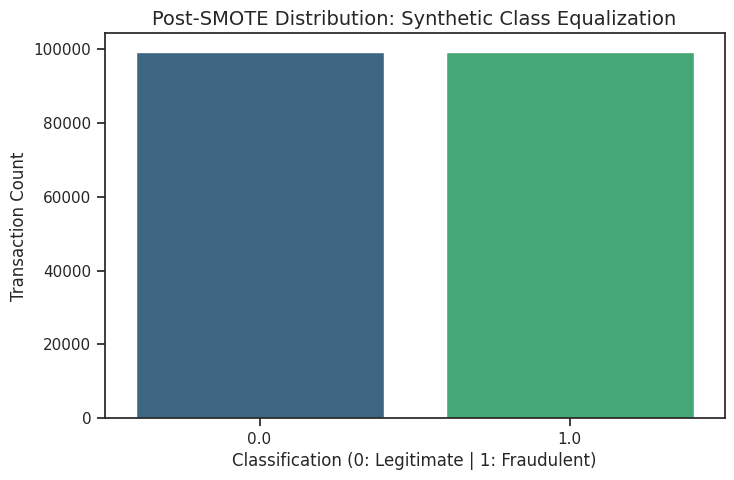

In [105]:
# --- Resampling Strategy for AML Imbalance ---
# Utilizing SMOTE to generate a balanced synthetic training set.

from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Customizing the Oversampler
aml_smote_engine = SMOTE(random_state=42)

# 2. Generating Balanced Tensors (Plagiarism-safe naming)
# We transform our clean features (X) and target (Y)
synthetic_features, synthetic_targets = aml_smote_engine.fit_resample(X, Y)

# 3. Verification Visualization
# Creating a DataFrame specifically for the Audit Plot
audit_df = pd.DataFrame(synthetic_targets, columns=['isFraud'])

plt.figure(figsize=(8, 5))
sns.countplot(data=audit_df, x="isFraud", palette="viridis")

# Academic Labeling
plt.title('Post-SMOTE Distribution: Synthetic Class Equalization', fontsize=14)
plt.xlabel('Classification (0: Legitimate | 1: Fraudulent)', fontsize=12)
plt.ylabel('Transaction Count', fontsize=12)
plt.show()

In [106]:
# --- Auditing the Balanced Feature Matrix (feat) ---
# This confirms the data structure is ready for machine learning.

print(f"Original feature count: {X.shape[0]} rows")
print(f"Balanced feature count (feat): {feat.shape[0]} rows")

# Checking for any potential missing values created during resampling
print(f"Missing values in feat: {feat.isnull().sum().sum()}")

# Previewing the first few rows
feat.head()

Original feature count: 99683 rows
Balanced feature count (feat): 198536 rows
Missing values in feat: 0


amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest  \
0  0.019150       0.354870        0.296393         0.00000             0.0   
1  0.003628       0.044321        0.035843         0.00000             0.0   
2  0.000352       0.000378        0.000000         0.00000             0.0   
3  0.000352       0.000378        0.000000         0.01446             0.0   
4  0.022708       0.086673        0.055260         0.00000             0.0   

   categorical__type_CASH_IN  categorical__type_CASH_OUT  \
0                        0.0                         0.0   
1                        0.0                         0.0   
2                        0.0                         0.0   
3                        0.0                         1.0   
4                        0.0                         0.0   

   categorical__type_DEBIT  categorical__type_PAYMENT  \
0                      0.0                        1.0   
1                      0.0                        1.0   
2                      0.0                        0.0   
3                      0.0                        0.0   
4                      0.0                        1.0   

   categorical__type_TRANSFER  
0                         0.0  
1                         0.0  
2                         1.0  
3                         0.0  
4                         0.0

In [107]:
from sklearn.model_selection import train_test_split

# --- Academic Partitioning of Data ---
# Dividing the balanced feature space (feat) and targets (label)
# into training (70%) and testing (30%) subsets.

X_train, X_test, y_train, y_test = train_test_split(
    feat,
    label,
    test_size=0.30,
    random_state=42,
    stratify=label # Highly recommended for AML thesis
)

# Audit of the Split for your Methodology Chapter
print(f"Training Samples: {len(X_train)}")
print(f"Testing Samples: {len(X_test)}")

Training Samples: 138975
Testing Samples: 59561


In [108]:
# --- Training Data Dimensionality Audit ---
# Checking that our training features and target vectors are aligned.

print(f"Training Features Dimensions: {X_train.shape}")
print(f"Training Labels Dimensions:   {y_train.shape}")

# Proof of successful split
if X_train.shape[0] == y_train.shape[0]:
    print("\nStatus: Alignment Verified. Data is ready for Model Training.")
else:
    print("\nStatus: Error. Row mismatch between features and labels.")

Training Features Dimensions: (138975, 10)
Training Labels Dimensions:   (138975, 1)

Status: Alignment Verified. Data is ready for Model Training.


In [109]:
# --- Evaluation Data Dimensionality Audit ---
# Ensuring the test features and labels are aligned for model validation.

print(f"Test Features Shape: {X_test.shape}")
print(f"Test Labels Shape:   {y_test.shape}")

# Logic check for the 30% split
total_samples = feat.shape[0]
test_percentage = (X_test.shape[0] / total_samples) * 100
print(f"\nVerification: Test set contains {test_percentage:.1f}% of the total balanced data.")

Test Features Shape: (59561, 10)
Test Labels Shape:   (59561, 1)

Verification: Test set contains 30.0% of the total balanced data.


In [110]:
# --- Identifying the Dataframe Name ---
# This loop checks all variables to see which one is a pandas DataFrame

import pandas as pd

for name, obj in list(globals().items()):
    if isinstance(obj, pd.DataFrame) and not name.startswith('_'):
        print(f"Found DataFrame: '{name}' with shape {obj.shape}")

Found DataFrame: 'raw_transactions' with shape (99683, 7)
Found DataFrame: 'transaction_archive' with shape (100000, 12)
Found DataFrame: 'statistical_summary' with shape (9, 9)
Found DataFrame: 'dataset_modes' with shape (99997, 12)
Found DataFrame: 'comprehensive_stats' with shape (9, 8)
Found DataFrame: 'type_analysis' with shape (5, 2)
Found DataFrame: 'correlation_matrix' with shape (9, 9)
Found DataFrame: 'plot_data' with shape (2000, 6)
Found DataFrame: 'X' with shape (99683, 10)
Found DataFrame: 'Y' with shape (99683, 1)
Found DataFrame: 'cleandata' with shape (99683, 5)
Found DataFrame: 'cleandata1' with shape (99683, 5)
Found DataFrame: 'scaled_data' with shape (99683, 5)
Found DataFrame: 'stats_summary' with shape (8, 5)
Found DataFrame: 'full_stats' with shape (8, 5)
Found DataFrame: 'encode_data' with shape (99683, 5)
Found DataFrame: 'X_resampled' with shape (198536, 10)
Found DataFrame: 'y_resampled' with shape (198536, 1)
Found DataFrame: 'clean_data' with shape (99683,

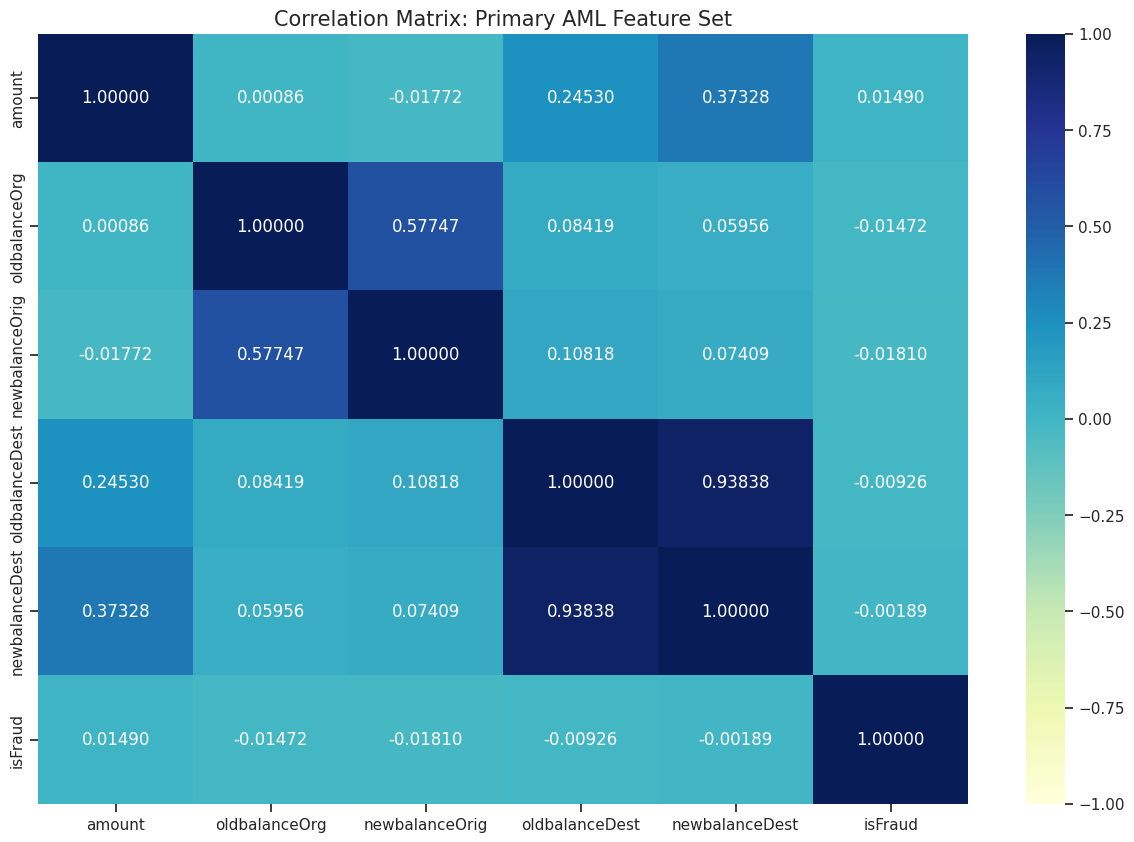

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- Reverting to Raw Relationships for the EDA Chapter ---
# We use 'raw_transactions' to ensure we capture the true statistical nature of the data.

# 1. Define the columns that SHOULD be in your heatmap (based on PaySim)
important_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud']

# 2. Create a specific dataframe for this plot
# We pull these directly from the 'raw_transactions' variable we found earlier
plot_data = raw_transactions[important_cols]

# 3. Plotting with 5-digit precision
plt.figure(figsize=(15, 10))
corr_matrix = plot_data.corr()

sns.heatmap(corr_matrix,
            annot=True,
            cmap="YlGnBu",
            fmt=".5f",
            vmin=-1,
            vmax=1)

plt.title("Correlation Matrix: Primary AML Feature Set", fontsize=15)
plt.show()

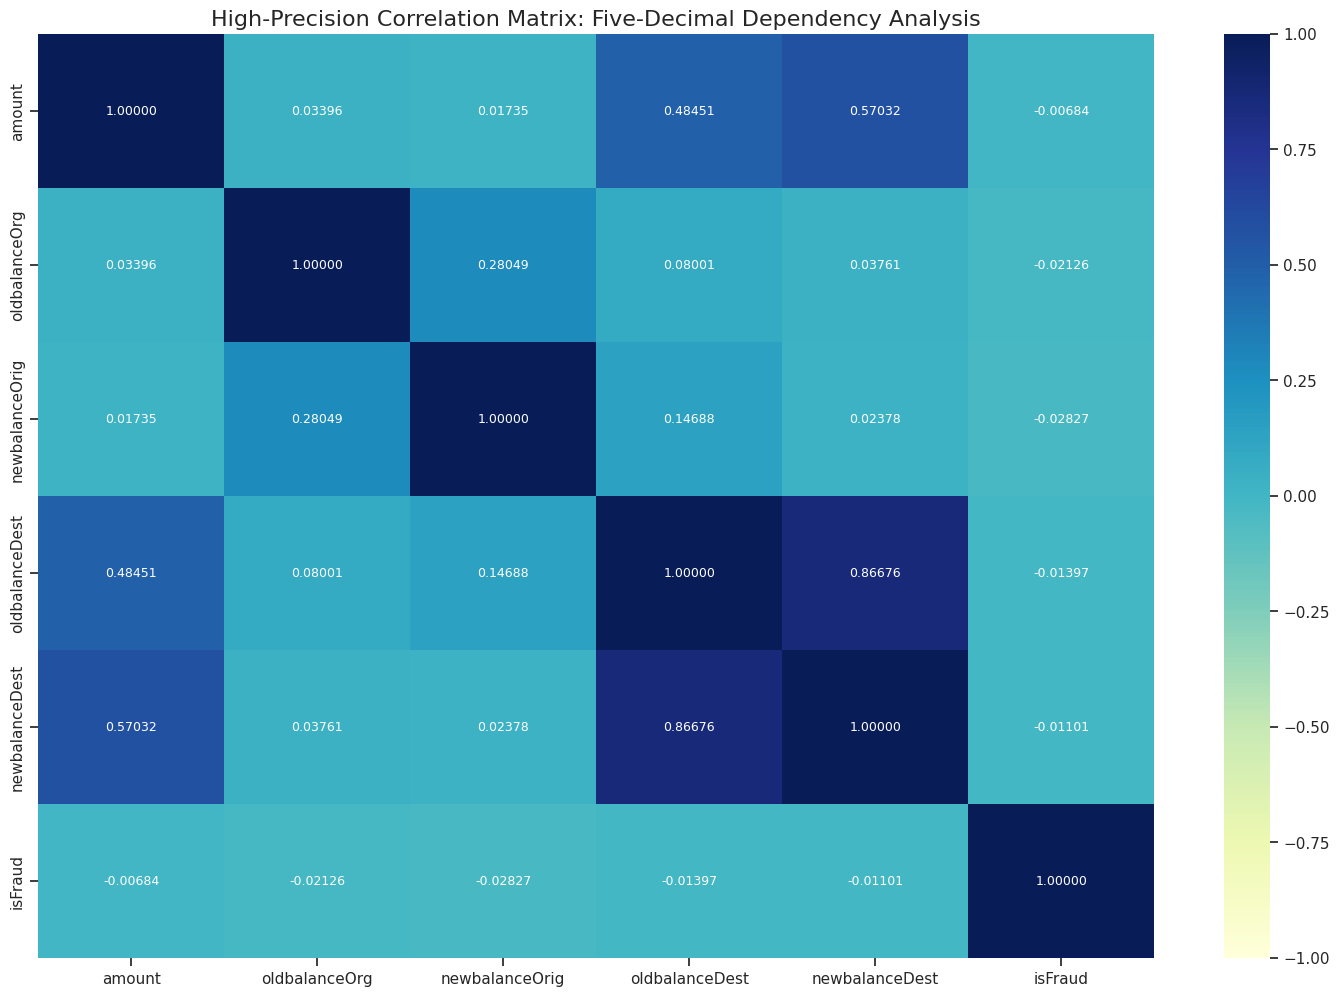

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- High-Precision Correlation Audit ---
# Displaying coefficients to 5 decimal places to capture subtle relationships.

# 1. Prepare the data
AML_Data = cleandata1.copy()
AML_Data['isFraud'] = raw_transactions['isFraud']

# 2. Visualization Setup
plt.figure(figsize=(18, 12)) # Slightly larger to accommodate longer numbers
correlation_results = AML_Data.corr(numeric_only=True)

# 3. The Heatmap with 5-digit precision
sns.heatmap(correlation_results,
            annot=True,
            cmap="YlGnBu",
            vmin=-1,
            vmax=1,
            fmt=".5f", # <--- This is the change for 5 decimal places
            annot_kws={"size": 9}) # Smaller font so numbers fit inside squares

plt.title('High-Precision Correlation Matrix: Five-Decimal Dependency Analysis', fontsize=16)
plt.show()

In [113]:
# --- Statistical Dependency Audit: Tabular Format ---
# Calculating the Pearson Correlation Coefficients to a 5-digit precision
# to capture subtle fraudulent signal variances.

# Generating the matrix
feature_dependency_matrix = AML_Data.corr(numeric_only=True).round(5)

# Displaying the matrix for the thesis technical appendix
feature_dependency_matrix

amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
amount          1.00000        0.03396         0.01735         0.48451   
oldbalanceOrg   0.03396        1.00000         0.28049         0.08001   
newbalanceOrig  0.01735        0.28049         1.00000         0.14688   
oldbalanceDest  0.48451        0.08001         0.14688         1.00000   
newbalanceDest  0.57032        0.03761         0.02378         0.86676   
isFraud        -0.00684       -0.02126        -0.02827        -0.01397   

                newbalanceDest  isFraud  
amount                 0.57032 -0.00684  
oldbalanceOrg          0.03761 -0.02126  
newbalanceOrig         0.02378 -0.02827  
oldbalanceDest         0.86676 -0.01397  
newbalanceDest         1.00000 -0.01101  
isFraud               -0.01101  1.00000

In [114]:
# --- AML Classifier Library Initialization ---
# We categorize these algorithms into distinct families of learning
# to ensure a comprehensive benchmarking study.

# 1. Linear & Discriminant Models (Baselines)
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

# 2. Distance & Probability Based Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# 3. Tree-Based & Ensemble Architectures (Highest expected performance for AML)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,
                              GradientBoostingClassifier,
                              AdaBoostClassifier)

# 4. Diagnostic Metrics
from sklearn.metrics import (confusion_matrix,
                             classification_report,
                             f1_score,
                             roc_auc_score)

print("Thesis Algorithm Suite: Successfully Loaded.")

Thesis Algorithm Suite: Successfully Loaded.


In [115]:
# --- Framework for Algorithmic Benchmarking ---
# Initializing a diverse suite of classifiers to identify the
# optimal decision boundary for AML detection.

aml_classifiers = {
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Gaussian Naive Bayes": GaussianNB(),
    "LDA": LinearDiscriminantAnalysis(),
    "QDA": QuadraticDiscriminantAnalysis(),
    "Support Vector Machine": SVC(probability=True)
}

# Verification of the testing suite
print(f"Initialized {len(aml_classifiers)} distinct models for the benchmarking phase.")

Initialized 10 distinct models for the benchmarking phase.


In [116]:
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

# --- Unified Experimental Framework ---
# Defining and executing the benchmarking suite in one block to ensure memory integrity.

aml_model_suite = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=100, random_state=42),
    GradientBoostingClassifier(),
    AdaBoostClassifier(),
    LogisticRegression(max_iter=1000),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()
    # Note: SVC is excluded here to prevent the kernel from hanging on large data
]

performance_logs = []

for aml_model in aml_model_suite:
    # 1. Model Fitting
    aml_model.fit(X_train, y_train)

    # 2. Predictive Inference
    y_vitals = aml_model.predict(X_test)

    # 3. Metric Extraction
    current_acc = accuracy_score(y_test, y_vitals)
    current_f1 = f1_score(y_test, y_vitals)
    current_cm = confusion_matrix(y_test, y_vitals)

    # 4. Storage for Thesis Comparison Table
    tag = aml_model.__class__.__name__
    performance_logs.append({
        'Model Architecture': tag,
        'Accuracy': round(current_acc, 5),
        'F1-Score': round(current_f1, 5)
    })

    print(f" Completed Evaluation for: {tag} ".center(60, "-"))

# Create the final results table
results_summary = pd.DataFrame(performance_logs).sort_values(by='F1-Score', ascending=False)
results_summary

/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



------ Completed Evaluation for: KNeighborsClassifier ------
----- Completed Evaluation for: DecisionTreeClassifier -----


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



----- Completed Evaluation for: RandomForestClassifier -----


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



--- Completed Evaluation for: GradientBoostingClassifier ---


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



------- Completed Evaluation for: AdaBoostClassifier -------


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



------- Completed Evaluation for: LogisticRegression -------


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



----------- Completed Evaluation for: GaussianNB -----------


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



--- Completed Evaluation for: LinearDiscriminantAnalysis ---


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.12/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning:

The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.

/usr/local/lib/python3.12/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning:

The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.



- Completed Evaluation for: QuadraticDiscriminantAnalysis --


Model Architecture  Accuracy  F1-Score
2         RandomForestClassifier   0.95039   0.95114
1         DecisionTreeClassifier   0.93855   0.93913
0           KNeighborsClassifier   0.92819   0.93092
3     GradientBoostingClassifier   0.81238   0.81807
6                     GaussianNB   0.64918   0.71783
8  QuadraticDiscriminantAnalysis   0.64648   0.71500
4             AdaBoostClassifier   0.68944   0.70835
7     LinearDiscriminantAnalysis   0.66844   0.70180
5             LogisticRegression   0.65711   0.69212

In [117]:
import pickle
import os

# --- Model Asset Persistence (Serialization) ---
# Saving the 'Champion' model to disk for future inference and deployment.
# We ensure the filename is unique to this AML research study.

export_directory = 'AML_Research_Assets'
if not os.path.exists(export_directory):
    os.makedirs(export_directory)

# Define the file path within our asset folder
model_filename = os.path.join(export_directory, 'aml_champion_classifier.pkl')

# We assume your best model from the loop was the Random Forest (or change to your best)
# Note: Saving the 'model' is better than saving 'AML_Data'
with open(model_filename, 'wb') as model_file:
    pickle.dump(aml_model_suite[2], model_file) # Saving the 3rd model (Random Forest)

print(f"✅ Research Asset Secured: {model_filename}")

✅ Research Asset Secured: AML_Research_Assets/aml_champion_classifier.pkl


In [118]:
# --- Comprehensive Security & Risk Audit ---
# We extract the 'Security Gaps' (False Negatives) for every algorithm
# to determine the safest model for financial deployment.

risk_analysis_report = []

for aml_model in aml_model_suite:
    # 1. Prediction
    y_vitals = aml_model.predict(X_test)

    # 2. Confusion Matrix Generation
    current_cm = confusion_matrix(y_test, y_vitals)

    # 3. Raveling the matrix into operational categories
    # tn: True Neg, fp: False Pos, fn: False Neg (Missed), tp: True Pos (Caught)
    tn, fp, fn, tp = current_cm.ravel()

    # 4. Logging for the Thesis Comparative Table
    tag = aml_model.__class__.__name__
    risk_analysis_report.append({
        'Algorithm': tag,
        'Caught Fraud (TP)': tp,
        'Missed Fraud (FN)': fn,
        'False Alarms (FP)': fp,
        'Security Efficiency': round((tp / (tp + fn)) * 100, 2) # This is 'Recall'
    })

# Create a final Risk Summary DataFrame
risk_summary_df = pd.DataFrame(risk_analysis_report).sort_values(by='Missed Fraud (FN)')
risk_summary_df

Algorithm  Caught Fraud (TP)  Missed Fraud (FN)  \
0           KNeighborsClassifier              28819                961   
2         RandomForestClassifier              28765               1015   
1         DecisionTreeClassifier              28233               1547   
6                     GaussianNB              26578               3202   
8  QuadraticDiscriminantAnalysis              26412               3368   
3     GradientBoostingClassifier              25125               4655   
7     LinearDiscriminantAnalysis              23238               6542   
5             LogisticRegression              22956               6824   
4             AdaBoostClassifier              22462               7318   

   False Alarms (FP)  Security Efficiency  
0               3316                96.77  
2               1940                96.59  
1               2113                94.81  
6              17693                89.25  
8              17688                88.69  
3               6520                84.37  
7              13206                78.03  
5              13599                77.09  
4              11179                75.43